# Fine-Tuning TinyLlama with LoRA on Databricks Dolly-15k

This project evaluates the performance of **TinyLlama**, a lightweight variant of **LLaMA**, fine-tuned using **LoRA** (Low-Rank Adaptation) on the [**databricks/databricks-dolly-15k**](https://huggingface.co/datasets/databricks/databricks-dolly-15k) dataset via Hugging Face.

---

## Methodology

- **Model**: `TinyLlama/TinyLlama-1.1B-Chat-v1.0`
- **Fine-tuning**: Applied **LoRA**, targeting transformer attention layers (`q_proj`, `v_proj`) for efficient parameter tuning.
- **Dataset**: Contains 15,000 instruction-response pairs across 8 task categories.
- **Prompting**: Standardized format using labeled `Instruction`, `Context`, and `Response` blocks.
- **Decoding**: Used **beam search** for more fluent and deterministic generation.
- **Evaluation**: Compared base and fine-tuned models using **BLEU**, **ROUGE-L**, and **BERTScore**, both globally and per task category.
- **Tokenization**: All inputs were tokenized using the tokenizer aligned with TinyLlama's pretraining setup.

---

## Results Summary

| Metric       | Overall Trend with LoRA |
|--------------|--------------------------|
| **BLEU**     | Mixed; modest gain in open-ended tasks, decline in structured tasks |
| **ROUGE-L**  | Minimal change |
| **BERTScore**| Minimal change |

---

## Conclusion

While LoRA fine-tuning on TinyLlama shows modest improvements or stability in open-ended and creative tasks, it underperforms or offers no improvement in structured, high-precision tasks like classification or extraction.
Overall, there was no clear improvement, reinforcing that task-specific adaptation may be necessary.


In [ ]:
!pip install -q datasets peft accelerate evaluate bitsandbytes
!pip install -q --upgrade datasets fsspec
!pip install -U transformers
!pip install rouge_score nltk absl-py
!pip install bert-score
!pip install tabulate

In [ ]:
from datasets import load_dataset
from collections import Counter
from transformers import AutoTokenizer,AutoModelForCausalLM,TrainingArguments
from transformers import DataCollatorForLanguageModeling,Trainer
from peft import LoraConfig, get_peft_model, TaskType, PeftModel, PeftConfig
from bert_score import score as bertscore
from tqdm import tqdm
from tabulate import tabulate
import json
import matplotlib.pyplot as plt
import torch
import evaluate

#suppress logging and progress bars
from datasets.utils.logging import disable_progress_bar
from huggingface_hub import hf_hub_download
import transformers.utils.logging as hf_logging
disable_progress_bar()
hf_logging.set_verbosity_error()
hf_logging.disable_progress_bar()

output_dir = "/workspace/tinyllama-dolly-lora"

## Dataset: databricks/databricks-dolly-15k

This project uses the [Dolly 15k](https://huggingface.co/datasets/databricks/databricks-dolly-15k) dataset, released by Databricks, for instruction-tuned fine-tuning of small language models.
The Dolly 15k dataset contains **15,000 instruction-following records** that  consist of the following fields:

| Field        | Description                                                                 |
|--------------|-----------------------------------------------------------------------------|
| `instruction`| The task description or instruction given to the model.                    |
| `context`    | Optional additional information or input required for the task.            |
| `response`   | The expected model output/answer to the instruction.                       |
| `category`   | The category of task (e.g., open QA, summarization, classification, etc.). |

The `context` field is optional and may be empty for many examples. When present, it provides useful supporting information for the instruction. The model should learn to generate appropriate responses both with and without additional context.




In [ ]:
# Load the Dolly 15k dataset from Hugging Face (created by Databricks)
dataset = load_dataset("databricks/databricks-dolly-15k")

# Split the dataset into training and validation sets (90% train, 10% validation)
dataset = dataset["train"].train_test_split(test_size=0.1)
train_data = dataset["train"]
val_data = dataset["test"]

# Display dataset structure and samples
print("\nDataset splits and sizes:")
print(dataset)
print(f"\nTrain size: {len(train_data)} samples")
print(f"Validation size: {len(val_data)} samples")

for i in range(1):
    print(f"\n--- Example {i+1} ---")
    print("Instruction:", train_data[i]["instruction"])
    print("Context    :", train_data[i]["context"])
    print("Response   :", train_data[i]["response"])
    print("Category   :", train_data[i]["category"])


Dataset splits and sizes:
DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 13509
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 1502
    })
})

Train size: 13509 samples
Validation size: 1502 samples

--- Example 1 ---
Instruction: Given this paragraph about history of China, what is the name of the river that nurtured China's civilization.
Context    : The history of the area now known as China has alternated between periods of prosperity, political unity, and peace and periods of war and statehood. The Yellow River nurtured China's civilization. Between eras of multiple kingdoms and warlordism, Chinese dynasties have ruled parts or all of China; in some eras control stretched as far as Xinjiang, Tibet and Inner Mongolia, as at present. The regions were occupied by other people-groups; often, non-settled peoples of the steppe identified as Mong

### Category Distribution in Training Data

To understand the types of tasks represented in the Dolly 15k dataset, we analyze the frequency of each `category` in the training split. The dataset includes the following task categories:
- open_qa
- general_qa
- classification
- brainstorming
- closed_qa   
- information_extraction
- summarization
- creative_writing



In [ ]:
# Extract all category labels from the training set
categories = [example["category"] for example in dataset["train"]]

# Count occurrences of each category
category_counts = Counter(categories)

print("Number of examples per category in the training set:\n")
for category, count in sorted(category_counts.items(), key=lambda x: -x[1]):
    print(f"{category:<25}: {count}")


Number of examples per category in the training set:

open_qa                  : 3349
general_qa               : 1971
classification           : 1939
brainstorming            : 1597
closed_qa                : 1586
information_extraction   : 1354
summarization            : 1063
creative_writing         : 650


### Prompt Formatting for Instruction Tuning

Before fine-tuning the model, we convert each example in the dataset into a structured text prompt. Including labeled sections `Instruction`, `Context`, and `Response` helps the model distinguish between input and expected output clearly.


**When `context` is present and non-empty:**

- Instruction: [instruction text]  
- Context: [context text]  
- Response: [response text]

**When `context` is missing or empty:**

- Instruction: [instruction text]  
- Response: [response text]


 The formatting is applied using the `.map()` method to both the training and validation splits.
This structured prompt format is compatible with supervised fine-tuning setups commonly used in instruction-tuned LLMs.


In [ ]:
# Function to format each example into a structured prompt for instruction tuning
def format_prompt(example):
    instruction = example["instruction"]
    context = example["context"]
    response = example["response"]

    # Include context only if it's non-empty and non-whitespace
    if context and context.strip():
        prompt = (
            f"### Instruction:\n{instruction}\n\n"
            f"### Context:\n{context}\n\n"
            f"### Response:\n{response}"
        )
    else:
        prompt = (
            f"### Instruction:\n{instruction}\n\n"
            f"### Response:\n{response}"
        )

    return {"text": prompt}

# Apply the formatting function to both train and validation splits
formatted_train = train_data.map(format_prompt)
formatted_val = val_data.map(format_prompt)

# Preview one formatted example
print(formatted_train[0]["text"])


### Instruction:
Given this paragraph about history of China, what is the name of the river that nurtured China's civilization.

### Context:
The history of the area now known as China has alternated between periods of prosperity, political unity, and peace and periods of war and statehood. The Yellow River nurtured China's civilization. Between eras of multiple kingdoms and warlordism, Chinese dynasties have ruled parts or all of China; in some eras control stretched as far as Xinjiang, Tibet and Inner Mongolia, as at present. The regions were occupied by other people-groups; often, non-settled peoples of the steppe identified as Mongolic, Turkic and Khitan. With thousands of years of continuous history, China is among the world's oldest civilizations and is regarded as one of the cradles of civilization.

### Response:
The river nurtured China's civilization is named the Yellow River


### Tokenization

To prepare the formatted prompts for model training, we tokenize the text using the Hugging Face `AutoTokenizer`. Tokenization converts raw text into input token IDs and attention masks, which the model uses during training.
We use the tokenizer from the `TinyLlama/TinyLlama-1.1B-Chat-v1.0` model to ensure compatibility. Since this model does not define a separate padding token, we set the padding token to be the same as the end-of-sequence (EOS) token.

We apply both padding and truncation during tokenization:

- **Truncation**: If a text sequence exceeds the specified `max_length`, it is truncated from the end.
- **Padding**: All sequences are padded to a fixed length using `padding="max_length"`.
- **Max Length**: We set `max_length=512`, which means all tokenized inputs will be exactly 512 tokens long. This value can be reduced (e.g., to 256) for faster training or to fit within memory constraints.


The tokenizer outputs two key fields:

- `input_ids`: The sequence of token IDs corresponding to the prompt text.
- `attention_mask`: A binary mask indicating which tokens are real (`1`) and which are padding (`0`).

These tokenized outputs are then converted to PyTorch tensors and used as input to the model for supervised instruction fine-tuning.


In [ ]:
# The model ID and corresponding tokenizer
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_id)

#Use the EOS token as pad token
tokenizer.pad_token = tokenizer.eos_token

# Tokenization function
def tokenize(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

# Apply tokenization to both training and validation sets
tokenized_train = formatted_train.map(tokenize, batched=True)
tokenized_val = formatted_val.map(tokenize, batched=True)
tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask"])
tokenized_val.set_format(type="torch", columns=["input_ids", "attention_mask"])

### Parameter-Efficient Fine-Tuning with LoRA

To fine-tune the `TinyLlama` model efficiently, we apply **LoRA (Low-Rank Adaptation)** using the `peft` library.
LoRA fine-tunes large pre-trained models by injecting low-rank trainable matrices into selected weight layers, typically in attention projections. Instead of updating the original weight matrix directly, LoRA adds a learned low-rank update. When fine-tuning with LoRA, only 1,126,400 out of 1,101,174,784 parameters are trainable, which is just 0.10% of the total model size.

In LoRA, the weight matrix $W$ is frozen, and a low-rank decomposition is added:

$$W_{\text{LoRA}} = W + \alpha \cdot B A$$
where:
- $ A \in \mathbb{R}^{r \times d_{\text{in}}} $ and $ B \in \mathbb{R}^{d_{\text{out}} \times r} $ are trainable matrices,
- $ r $ is the rank of the low-rank update (a hyperparameter),
- $\alpha$ is the scaling factor that controls the magnitude of the update.

This formulation allows fine-tuning only the smaller matrices $A$ and $B$, reducing the number of trainable parameters:

$$
\text{Trainable Params (LoRA)} = r \cdot (d_{\text{in}} + d_{\text{out}})
$$

compared to:

$$
\text{Trainable Params (Full)} = d_{\text{in}} \cdot d_{\text{out}}
$$

The product $B A x$ represents a low-rank approximation of the update to $W x$.
We define the following configuration when wrapping the base model:

- **`r = 8`**: This sets the rank of the low-rank decomposition matrices injected into the model.

- **`lora_alpha = 16`**: Typically set to 2x or 4× the value of `r`.

- **`target_modules = ["q_proj", "v_proj"]`**: These refer to the query and value projection layers in the model’s attention mechanism.

- **`lora_dropout = 0.05`**:  Dropout applied to LoRA weights during training for regularization.



In [ ]:
# Load the base model
model = AutoModelForCausalLM.from_pretrained(
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    device_map="auto",
    load_in_8bit=True
)

# Define the LoRA configuration
lora_config = LoraConfig(
    r=8,                                 # Rank of the low-rank decomposition
    lora_alpha=16,                       # Scaling factor for the LoRA updates
    target_modules=["q_proj", "v_proj"], # Attention projection layers to inject LoRA into
    lora_dropout=0.05,                   # Dropout applied to LoRA layers
    bias="none",
    task_type=TaskType.CAUSAL_LM         # Specify the task type as causal language modeling
)

# Inject LoRA adapters into the base model
model = get_peft_model(model, lora_config)

# Print the number of trainable parameters (only LoRA layers are trainable)
model.print_trainable_parameters()

trainable params: 1,126,400 || all params: 1,101,174,784 || trainable%: 0.1023


### Training Setup with Hugging Face Transformers

We use the Hugging Face `transformers` library to train a causal language model. The training process is managed using the built-in `Trainer` API and
is organized into three main components:

#### 1. `TrainingArguments`

This block defines the configuration for the training run, including output paths, batch sizes, number of epochs, logging and evaluation strategy, precision (fp16), and how the best model is selected.
#### 2. `DataCollatorForLanguageModeling`

This component dynamically batches the tokenized inputs during training. Since we are training a causal language model, masked language modeling (MLM) is disabled.

#### 3. `Trainer`

The Hugging Face `Trainer` implements the full training loop. It uses the configuration from `TrainingArguments` and the `data_collator` to run the training process end-to-end.


In [ ]:
# Define training hyperparameters
training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=32,             # Batch size per device for training
    per_device_eval_batch_size=32,              # Batch size per device for evaluation
    num_train_epochs=5,                         # Number of training epochs
    learning_rate=2e-4,                         # Learning rate
    logging_steps=250,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    fp16=True,                                  # Use float16 precision
    load_best_model_at_end=True,                # Load the best model (based on eval metric) after training
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

# Define the data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # Masked Language Modeling is disabled for causal LM tasks
)

# Set up the Hugging Face Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator
)

### Model Training

We initiate the training process using the Hugging Face `Trainer`. This step begins fine-tuning the model on the tokenized and formatted Dolly dataset using the configuration defined earlier.
The training process takes approximately **1 hour** on an **NVIDIA A100 PCIe GPU**.


In [ ]:
# Start model training
trainer.train()

### Training Loss Visualization

The following plots show the training and validation loss over time based on the logged trainer state:

- **Left Plot**: Loss vs. Training Step  
- **Right Plot**: Loss vs. Epoch

From the plots, we observe that the training loss is steadily decreasing.
Validation loss plateaus after a few epochs, suggesting that the model's performance on unseen data is converging to its generalization limit.


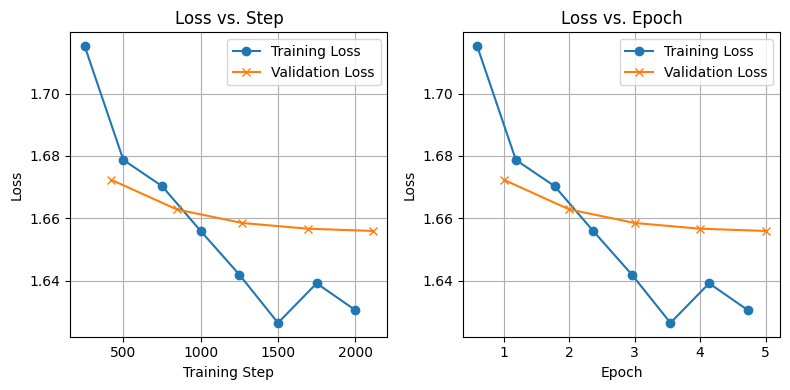

In [ ]:
# Load state from saved checkpoint
log_file = "/workspace/tinyllama-dolly-lora/checkpoint-2115/trainer_state.json"
with open(log_file, "r") as f:
    state = json.load(f)

# Collect losses and steps/epochs
train_steps, train_losses_step = [], []
eval_steps, eval_losses_step = [], []
train_epochs, train_losses_epoch = [], []
eval_epochs, eval_losses_epoch = [], []

for entry in state["log_history"]:
    if "loss" in entry:
        if "step" in entry:
            train_steps.append(entry["step"])
            train_losses_step.append(entry["loss"])
        if "epoch" in entry:
            train_epochs.append(entry["epoch"])
            train_losses_epoch.append(entry["loss"])
    if "eval_loss" in entry:
        if "step" in entry:
            eval_steps.append(entry["step"])
            eval_losses_step.append(entry["eval_loss"])
        if "epoch" in entry:
            eval_epochs.append(entry["epoch"])
            eval_losses_epoch.append(entry["eval_loss"])


fig, axs = plt.subplots(1, 2, figsize=(8,4))

# Plot loss vs. training step
axs[0].plot(train_steps, train_losses_step, marker="o", label="Training Loss")
axs[0].plot(eval_steps, eval_losses_step, marker="x", label="Validation Loss")
axs[0].set_xlabel("Training Step")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss vs. Step")
axs[0].legend()
axs[0].grid(True)

# Plot loss vs. epoch
axs[1].plot(train_epochs, train_losses_epoch, marker="o", label="Training Loss")
axs[1].plot(eval_epochs, eval_losses_epoch, marker="x", label="Validation Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].set_title("Loss vs. Epoch")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


### Comparing Base Model vs. LoRA Fine-Tuned Model

In this step, we compare the performance of the original (pretrained) base model with the LoRA fine-tuned version.

- We use the **TinyLlama/TinyLlama-1.1B-Chat-v1.0** model as the base.
- We load the **LoRA fine-tuned checkpoint** and apply it to the same base model architecture.

This setup allows us to run evaluation on the same validation data and directly compare the loss between the base and the fine-tuned model.


In [ ]:
# Model ID and LoRA checkpoint path
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
checkpoint_path = "/workspace/tinyllama-dolly-lora/checkpoint-2115"

tokenized_val = tokenized_val.map(lambda x: {"labels": x["input_ids"]})
tokenized_val.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load the base model (no fine-tuning)
base_model_clean = AutoModelForCausalLM.from_pretrained(model_id).to("cuda")

# Load the fine-tuned LoRA model by merging LoRA weights onto a base model
lora_model = AutoModelForCausalLM.from_pretrained(model_id)
lora_model = PeftModel.from_pretrained(lora_model, checkpoint_path).to("cuda")

### Evaluation: Base Model vs. LoRA Fine-Tuned Model

We evaluate both the original base model and the LoRA fine-tuned model on the same validation set to compare their performance. Loss values represent the average cross-entropy loss over the validation set.


| Model             | Eval Loss | Notes                          |
|------------------|-----------|--------------------------------|
| Base Model        | 2.018     | Pretrained only, no fine-tuning |
| LoRA Fine-Tuned   | 1.591     | Fine-tuned using LoRA on Dolly dataset |


The LoRA fine-tuned model shows a **significantly lower evaluation loss** compared to the base model, indicating improved performance on the validation set after fine-tuning.


In [ ]:
# Create a Trainer for the base model
trainer_base = Trainer(
    model=base_model_clean,
    args=training_args,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
)

# Create a Trainer for the LoRA fine-tuned model
trainer_lora = Trainer(
    model=lora_model,
    args=training_args,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
)

# Evaluate both models on the same validation set and print losses
print("Base model eval loss:", trainer_base.evaluate()["eval_loss"])
print("LoRA model eval loss:", trainer_lora.evaluate()["eval_loss"])

### Prompt Formatting and Response Generation

This section describes how we structure prompts and generate responses from a fine-tuned language model using Hugging Face Transformers.

#### Prompt Formatting (`format_prompt`)

The `format_prompt` function constructs a structured prompt based on an instruction and optional input (or context).
This formatting mirrors the structure used during supervised fine-tuning.
The prompt follows one of the following formats:

- **With input/context:** `### Instruction: [instruction]`, `### Input: [context]`, `### Response:`
- **Without input/context:** `### Instruction: [instruction]`, `### Response:`


#### Response Generation (`generate_response`)

The `generate_response` function uses the model to generate a textual output given a prompt. It leverages the Hugging Face `generate()` method **beam search** with 5 beams. Beam search explores multiple likely continuations at each step and keeps the top `num_beams` candidates. This helps find higher-quality, more coherent responses compared to greedy decoding.

In [ ]:
# Format an instruction-following prompt for generation
def format_prompt(instruction, input_text=""):
    if input_text:
        return (
            f"### Instruction:\n{instruction}\n\n"
            f"### Input:\n{input_text}\n\n"
            f"### Response:\n"
        )
    else:
        return (
            f"### Instruction:\n{instruction}\n\n"
            f"### Response:\n"
        )

# Generate a response from the model given a prompt
def generate_response(model, prompt, max_new_tokens=100):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        num_beams=5,              # Use beam search
        early_stopping=True,
        no_repeat_ngram_size=2
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

### Prompt-Based Evaluation: Base Model vs. LoRA Fine-Tuned Model

To qualitatively evaluate the effect of fine-tuning, we compare the outputs of the base model and the LoRA fine-tuned model across a small set of prompts. One example is shown below, with additional examples included in the cell output.

### Example:

**Instruction:**  
Explain black holes in simple terms.

---

**Base Model Output:**

A black hole is a region in space where the gravitational pull is so strong that nothing, not even light, can escape from it. Black holes are formed when a massive star runs out of fuel and collapses under its own gravity. The collapse of the star creates a singularity, a point of infinite density and curvature, which is the point at which space and time become indistinguishable. Once a star has collapsed to this point, there is no escape for anything

---

**LoRA Fine-Tuned Model Output:**

A black hole is a region of spacetime where the gravitational force is so strong that nothing, not even light, can escape from it. This is because the force of gravity is proportional to the square of the distance between the object and the event horizon, which is the point at which the curvature of space-time becomes so great that light can no longer escape. Black holes are thought to be formed when a massive object, such as a star, collapses under its own gravity.

---

**Comparison:**

Both models provide technically accurate answers. However, the LoRA fine-tuned model delivers a more complete and fluent explanation. The base model's response is informative but cuts off abruptly, while the fine-tuned version includes a more polished ending. This suggests that fine-tuning helps improve the model's coherence and completeness.


In [ ]:
# Example prompts for evaluating base and fine-tuned models
prompts = [
    "Explain black holes in simple terms.",
    "Give me 3 pros and 3 cons of remote work.",
    "Write a haiku about artificial intelligence.",
    "Why is exercise important for mental health?",
    "Summarize the story of Little Red Riding Hood in one paragraph."
]

# Generate and compare responses from both models
for i, instruction in enumerate(prompts):
    formatted = format_prompt(instruction)

    print(f"\n=== Prompt {i+1} ===")
    print("Prompt:")
    print(formatted)

    print("\nBase Model Response:")
    print(generate_response(base_model_clean, formatted))

    print("\nLoRA Fine-Tuned Model Response:")
    print(generate_response(lora_model, formatted))



=== Prompt 1 ===
Prompt:
### Instruction:
Explain black holes in simple terms.

### Response:


Base Model Response:
### Instruction:
Explain black holes in simple terms.

### Response:
A black hole is a region in space where the gravitational pull is so strong that nothing, not even light, can escape from it. Black holes are formed when a massive star runs out of fuel and collapses under its own gravity. The collapse of the star creates a singularity, a point of infinite density and curvature, which is the point at which space and time become indistinguishable. Once a star has collapsed to this point, there is no escape for anything

LoRA Fine-Tuned Model Response:
### Instruction:
Explain black holes in simple terms.

### Response:
A black hole is a region of spacetime where the gravitational force is so strong that nothing, not even light, can escape from it. This is because the force of gravity is proportional to the square of the distance between the object and the event horizon,

### BLEU and ROUGE Scores

We evaluate the base and LoRA fine-tuned models using the two metrics **BLEU** and **ROUGE-L**.

#### BLEU (Bilingual Evaluation Understudy)

BLEU measures the overlap between n-grams in the model-generated output and the reference text. It is precision-oriented, meaning it evaluates how much of the generated text matches the reference. BLEU is commonly used for tasks like translation or structured generation, where exact phrasing matters.


#### ROUGE-L (Recall-Oriented Understudy for Gisting Evaluation)

ROUGE-L measures the longest common subsequence between the generated output and reference, capturing recall-oriented aspects of content overlap. It is especially useful for summarization and instruction following, where capturing the right information is more important than matching exact phrasing.

---

### Evaluation Results (on 100 validation samples)

| Model          | BLEU Score | ROUGE-L Score |
|----------------|------------|----------------|
| Base Model     | 0.0684     | 0.1652         |
| LoRA Fine-Tuned| 0.0637     | 0.1537         |

---

Both models achieve similar scores, but the base model slightly outperforms the LoRA fine-tuned model on both BLEU and ROUGE-L metrics in this evaluation. This result may reflect that the LoRA model, while more fluent and expressive in some qualitative examples, sometimes diverges more from reference wording.
Overall, this suggests that LoRA fine-tuning may require additional tuning to consistently improve in metrics like BLEU and ROUGE.


In [ ]:
# Load BLEU and ROUGE metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

# Evaluate a model on a subset of the validation dataset
def evaluate_model(model, dataset, n_samples=100):
    predictions = []
    references = []

    # Generate predictions for the first n_samples examples
    for example in dataset.select(range(n_samples)):
        prompt = format_prompt(example["instruction"], example.get("context", ""))
        target = example["response"]

        output = generate_response(model, prompt)
        predictions.append(output.strip())
        references.append(target.strip())

    # Compute BLEU and ROUGE-L scores
    bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
    rouge_score = rouge.compute(predictions=predictions, references=references)

    return {"BLEU": bleu_score["bleu"], "ROUGE-L": rouge_score["rougeL"]}

# Evaluate base model
print("Evaluating Base Model...")
base_scores = evaluate_model(base_model_clean, formatted_val)
print("Base Model:", base_scores)

# Evaluate LoRA fine-tuned model
print("\nEvaluating LoRA Model...")
lora_scores = evaluate_model(lora_model, formatted_val)
print("LoRA Model:", lora_scores)

### Semantic Evaluation with BERTScore

In addition to BLEU and ROUGE, we use **BERTScore** to evaluate the semantic similarity between model-generated responses and reference answers.
BERTScore compares each token in the prediction and reference using contextualized embeddings from BERT. It computes three metrics:

- **Precision**: How much of the predicted meaning is aligned with the reference.
- **Recall**: How much of the reference meaning is captured by the prediction.
- **F1**: The harmonic mean of precision and recall.

This metric is especially useful when the wording between the prediction and reference differs, but the underlying meaning is preserved.

---

### Evaluation Results (on 100 validation samples)

| Model           | BERTScore Precision | BERTScore Recall | BERTScore F1 |
|-----------------|---------------------|------------------|--------------|
| Base Model      | 0.8235              | 0.8678           | 0.8445       |
| LoRA Fine-Tuned | 0.8169              | 0.8689           | 0.8414       |

---

- The **base model** achieves slightly higher precision and F1 scores, indicating closer alignment of generated content with reference phrasing.
- The **LoRA fine-tuned model** shows marginally higher recall, suggesting it captures more of the reference meaning, even if not always phrased the same way.

These results align with earlier qualitative observations: the LoRA model tends to be more expressive and expansive, while the base model may hew more closely to the original response structure.


In [ ]:
# Evaluate a model using BERTScore on a subset of the dataset
def evaluate_with_bertscore(model, dataset, n_samples=100):
    predictions = []
    references = []

    # Generate predictions and collect corresponding references
    for example in dataset.select(range(n_samples)):
        prompt = format_prompt(example["instruction"], example.get("context", ""))
        reference = example["response"].strip()
        output = generate_response(model, prompt).strip()

        predictions.append(output)
        references.append(reference)

    # Compute BERTScore
    P, R, F1 = bertscore(predictions, references, lang="en", verbose=True)
    return {
        "BERTScore Precision": P.mean().item(),
        "BERTScore Recall": R.mean().item(),
        "BERTScore F1": F1.mean().item()
    }

# Evaluate both models
print("Evaluating Base Model with BERTScore...")
base_bert = evaluate_with_bertscore(base_model_clean, formatted_val)

print("\nEvaluating LoRA Model with BERTScore...")
lora_bert = evaluate_with_bertscore(lora_model, formatted_val)

print("\nResults:")
print("Base Model:", base_bert)
print("LoRA Model:", lora_bert)

### Category-wise Evaluation

To analyze how the model performs across different task types, we evaluate its outputs by category using a subset of examples from each.
For each category, we select up to 50 examples.
The model generates a response, which is compared to the reference using the  metrics: **BLEU**, **ROUGE-L**, and **BERTScore (F1)**.

In [ ]:
# Load evaluation metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

# Evaluate model performance by category
def evaluate_by_category(model, dataset, categories, max_samples_per_cat=50):
    results = {}

    for category in categories:
        # Filter dataset by category
        filtered = dataset.filter(lambda x: x["category"] == category)
        subset = filtered.select(range(min(max_samples_per_cat, len(filtered))))

        predictions = []
        references = []

        # Generate predictions for each example in the category
        for example in tqdm(subset, desc=f"Evaluating {category}"):
            prompt = format_prompt(example["instruction"], example.get("context", ""))
            reference = example["response"].strip()
            prediction = generate_response(model, prompt).strip()

            predictions.append(prediction)
            references.append(reference)

        # Compute BLEU score
        bleu = bleu_metric.compute(
            predictions=predictions,
            references=[[ref] for ref in references]
        )["bleu"]

        # Compute ROUGE-L score
        rouge = rouge_metric.compute(
            predictions=predictions,
            references=references
        )["rougeL"]

        # Compute BERTScore (F1)
        _, _, f1 = bertscore(predictions, references, lang="en", verbose=False)

        # Store results for the category
        results[category] = {
            "BLEU": bleu,
            "ROUGE-L": rouge,
            "BERTScore F1": f1.mean().item()
        }

    return results


### Category-wise Evaluation Results

We evaluated both the base model and the LoRA fine-tuned model across different task categories using **BLEU**, **ROUGE-L**, and **BERTScore (F1)**. The table below summarizes the results:

| Category               | BLEU (Base) | BLEU (LoRA) | ROUGE-L (Base) | ROUGE-L (LoRA) | BERT F1 (Base) | BERT F1 (LoRA) |
|------------------------|-------------|-------------|----------------|----------------|----------------|----------------|
| closed_qa              | 0.090       | 0.085       | 0.204          | 0.184          | 0.860          | 0.857          |
| creative_writing       | 0.008       | 0.013       | 0.148          | 0.146          | 0.834          | 0.835          |
| general_qa             | 0.039       | 0.046       | 0.171          | 0.172          | 0.845          | 0.848          |
| brainstorming          | 0.038       | 0.041       | 0.163          | 0.153          | 0.839          | 0.840          |
| open_qa                | 0.036       | 0.041       | 0.168          | 0.155          | 0.840          | 0.836          |
| information_extraction | 0.086       | 0.081       | 0.193          | 0.187          | 0.845          | 0.841          |
| classification         | 0.099       | 0.072       | 0.244          | 0.184          | 0.855          | 0.843          |
| summarization          | 0.138       | 0.134       | 0.279          | 0.272          | 0.871          | 0.870          |

---


- **Summarization** yields the highest scores across all metrics for both models. This suggests both models are relatively strong in this category.
- **Creative writing** shows very low BLEU and ROUGE-L scores. BERTScore remains reasonably high, indicating semantic similarity despite lexical differences.
- **Classification** shows a noticeable drop in BLEU and ROUGE-L for the LoRA model compared to the base model.
- **General QA and brainstorming** see slight improvements in BLEU and BERTScore under LoRA fine-tuning, suggesting better instruction adherence and fluency.

---

### Conclusion

LoRA fine-tuning leads to modest improvements or stability in some open-ended categories (e.g., QA, creative writing), while slightly underperforming in structured tasks like classification and information extraction. This reinforces the idea that **LoRA improves fluency and creativity**, but **may require further alignment or format constraints** for high-precision tasks.


In [ ]:
# Extract all unique categories from the validation set
categories = list(set(example["category"] for example in formatted_val))

# Evaluate base model by category
print("Evaluating Base Model...")
base_cat_results = evaluate_by_category(base_model_clean, formatted_val, categories)

# Evaluate LoRA fine-tuned model by category
print("\nEvaluating LoRA Model...")
lora_cat_results = evaluate_by_category(lora_model, formatted_val, categories)

table = []
for cat in categories:
    table.append([
        cat,
        f"{base_cat_results[cat]['BLEU']:.3f}",
        f"{lora_cat_results[cat]['BLEU']:.3f}",
        f"{base_cat_results[cat]['ROUGE-L']:.3f}",
        f"{lora_cat_results[cat]['ROUGE-L']:.3f}",
        f"{base_cat_results[cat]['BERTScore F1']:.3f}",
        f"{lora_cat_results[cat]['BERTScore F1']:.3f}",
    ])

headers = [
    "Category",
    "BLEU (Base)", "BLEU (LoRA)",
    "ROUGE-L (Base)", "ROUGE-L (LoRA)",
    "BERT F1 (Base)", "BERT F1 (LoRA)"
]

print(tabulate(table, headers=headers, tablefmt="grid"))